# 환경설정 및 탐색 준비

## 라이브러리 임포트

In [2]:
import tensorflow as tf, keras, keras_tuner as kt
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
import os

2025-02-18 13:05:22.335904: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-18 13:05:22.345092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739851522.356650   64696 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739851522.359584   64696 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 13:05:22.370614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 데이터셋 적재 및 전처리
### 데이터셋 적재

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

#### 데이터셋 전처리 관련 설정

In [4]:
label_names = ['airplane',
               'automobile',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck']

def show_images_with_labels(indexes, dataset):
    num_images = len(indexes)
    num_rows = num_images//5 + 1
    
    image = dataset[0]
    label = dataset[1]
    
    plt.figure(figsize=(10, (num_rows) * 3))
    for i in range(len(indexes)):
        plt.subplot(num_rows, 5, i + 1)
        plt.imshow(image[indexes[i]])
        plt.title(f'index: {indexes[i]}\nlabel: {label_names[int(label[indexes[i]])]}')
        plt.axis('off')
    plt.show()

def fix_errornouse_labels(dict, labels):
    for index, correct_label in dict.items():
        labels[index] = label_names.index(correct_label)
        
def prune_dataset(indexes, dataset):
    image = dataset[0]
    label = dataset[1]
    
    for index in indexes:
        image = np.delete(image, index, 0)
        label = np.delete(label, index, 0)
    
    return image, label
    

#### 데이터셋 일부 샘플 확인 - 훈련 샘플

/tmp/ipykernel_64696/2118702580.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'index: {indexes[i]}\nlabel: {label_names[int(label[indexes[i]])]}')


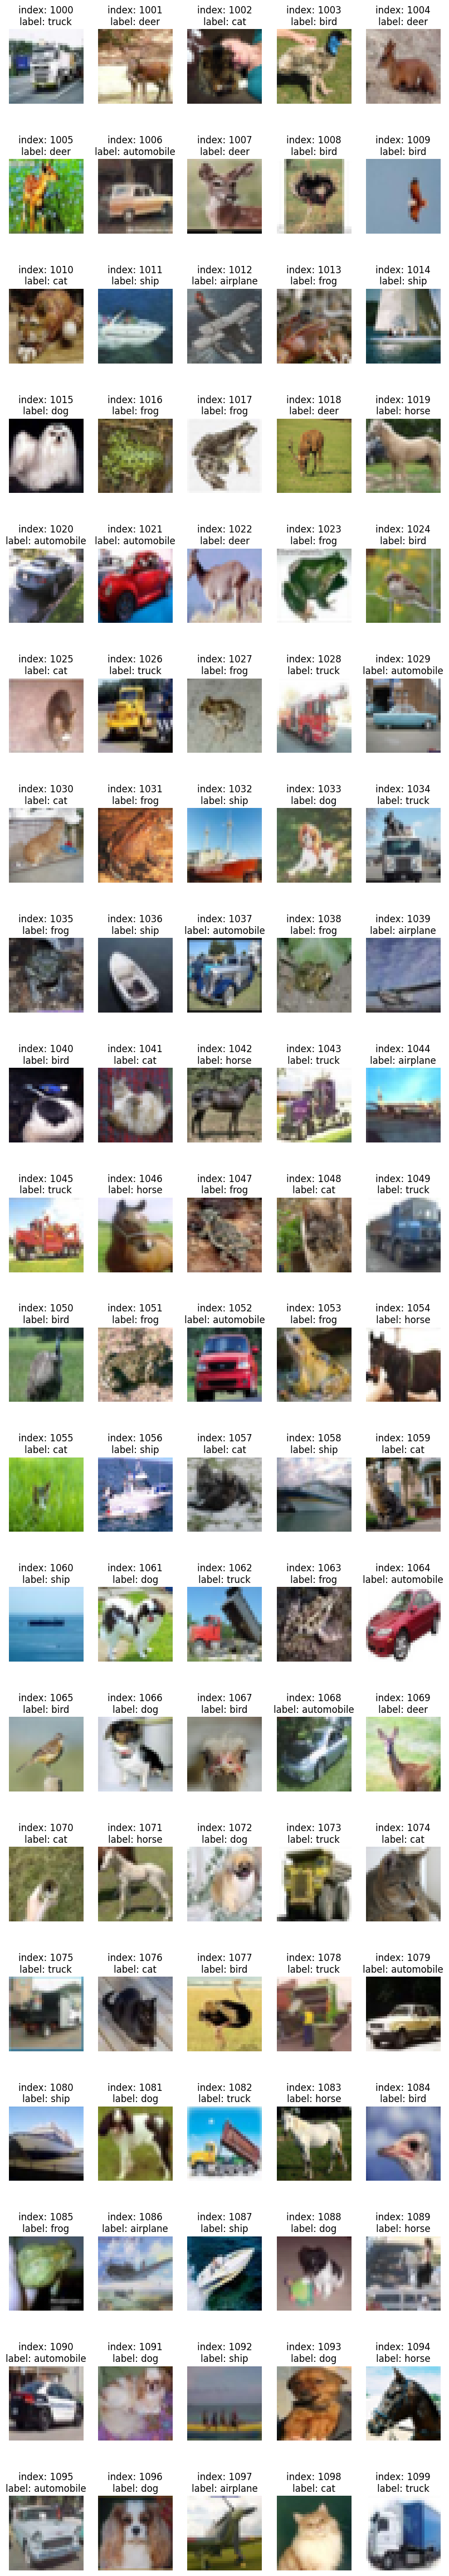

In [5]:
show_images_with_labels([x for x in range(1000, 1100)],
                       (x_train, y_train))

#### 데이터셋 일부 샘플 확인 - 테스트 샘플

/tmp/ipykernel_64696/2118702580.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'index: {indexes[i]}\nlabel: {label_names[int(label[indexes[i]])]}')


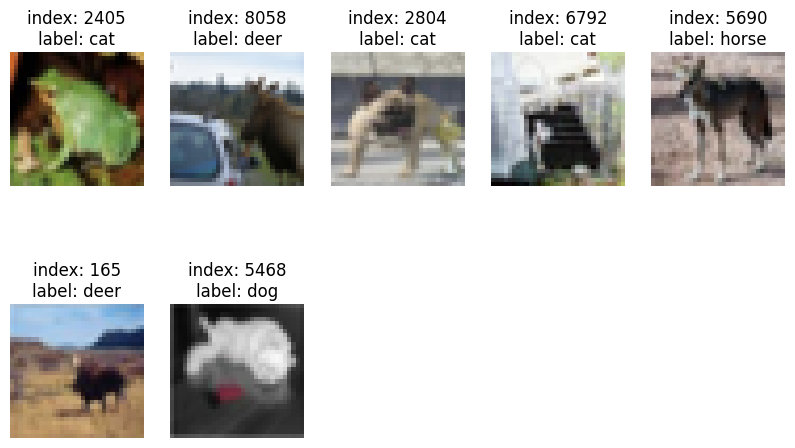

In [6]:
show_images_with_labels([2405,
                         8058,
                         2804,
                         6792,
                         5690,
                         165,
                         5468,],
                        (x_test, y_test))

### 데이터셋 전처리
#### 라벨 오류 수정 및 확인 - 테스트 샘플

/tmp/ipykernel_64696/2118702580.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'index: {indexes[i]}\nlabel: {label_names[int(label[indexes[i]])]}')


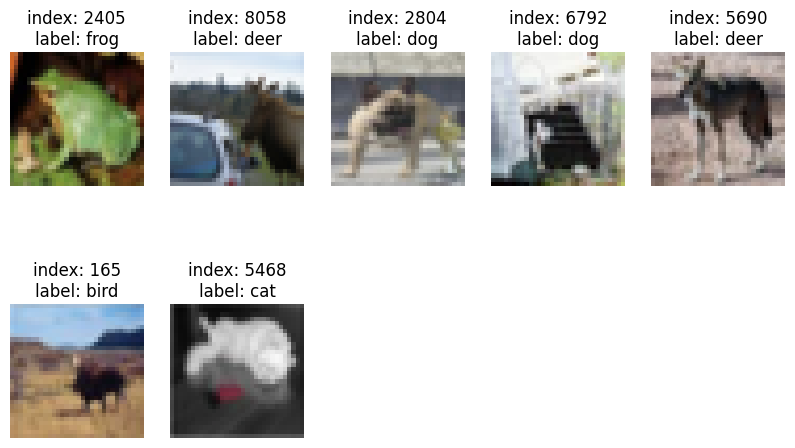

In [7]:
fix_errornouse_labels({2405: "frog",
                       2804: "dog",
                       5690: "deer",
                       165:"bird",
                       6792: "dog",
                       5468: "cat"},
                      y_test)

show_images_with_labels([2405,
                         8058,
                         2804,
                         6792,
                         5690,
                         165,
                         5468,],
                        (x_test, y_test))

# 모델 탐색
## 하이퍼모델 및 튜너 설정
### 하이퍼모델 정의

In [22]:
class SimpleModel(kt.HyperModel):
    def build(self, hp):
        units = hp.Int("units", min_value=128, max_value=768, step=128)
        dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
        learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        
        kernel_size_1 = hp.Int("kernel_size_1", min_value=3, max_value=5, step=2)
        kernel_size_2 = hp.Int("kernel_size_2", min_value=3, max_value=5, step=2)

        model = keras.Sequential()

        model.add(keras.layers.Input(shape=(32, 32, 3)))
        model.add(keras.layers.Conv2D(32, kernel_size_1, activation="relu"))
        model.add(keras.layers.AveragePooling2D((2, 2)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Conv2D(64, kernel_size_2, activation="relu"))
        model.add(keras.layers.AveragePooling2D((2, 2)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(units, activation='relu'))
        model.add(keras.layers.Dropout(dropout_rate))
        model.add(keras.layers.Dense(10, activation="softmax"))

        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )
        
        return model
    
hypermodel = SimpleModel()

### 튜너 설정

In [ ]:
tuner = kt.BayesianOptimization(
    hypermodel,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_trials=100,
    executions_per_trial=2,
    directory="keras_tuner_proj",
    project_name="simple_model",
    overwrite=False
)

tuner.search_space_summary()

I0000 00:00:1739851527.469697   64696 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 768, 'step': 128, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
kernel_size_1 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': 'linear'}
kernel_size_2 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': 'linear'}


## 하이퍼모델 탐색

In [10]:
tuner.search(x_train, keras.utils.to_categorical(y_train),
             epochs=100,
             validation_split=0.2,
             callbacks=[keras.callbacks.EarlyStopping(patience=1)])

Trial 50 Complete [00h 01m 10s]
val_accuracy: 0.6915499866008759

Best val_accuracy So Far: 0.7081500291824341
Total elapsed time: 00h 45m 05s

Search: Running Trial #51

Value             |Best Value So Far |Hyperparameter
768               |768               |units
0.4               |0.4               |dropout_rate
0.0001            |0.0001            |learning_rate
3                 |3                 |kernel_size_1
3                 |3                 |kernel_size_2

Epoch 1/100
 472/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3106 - loss: 2.1904

KeyboardInterrupt: 

## 탐색된 하이퍼모델 재학습 및 시각화
### 재학습

In [24]:
best_model = hypermodel.build(tuner.get_best_hyperparameters()[0])

history = best_model.fit(x_train, keras.utils.to_categorical(y_train),
                        epochs=100,
                        validation_split=0.2,
                        callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3691 - loss: 1.9223 - val_accuracy: 0.5622 - val_loss: 1.2824
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5623 - loss: 1.2551 - val_accuracy: 0.6097 - val_loss: 1.1527
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6289 - loss: 1.0602 - val_accuracy: 0.6188 - val_loss: 1.0916
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6842 - loss: 0.9071 - val_accuracy: 0.6476 - val_loss: 1.0357
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7232 - loss: 0.7970 - val_accuracy: 0.6678 - val_loss: 0.9913
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7584 - loss: 0.6952 - val_accuracy: 0.6803 - val_loss: 0.9535
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7859 - loss: 0.6236 - val_accuracy: 0.6718 - val_loss: 0.9733
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8155 - loss: 0

### 시각화

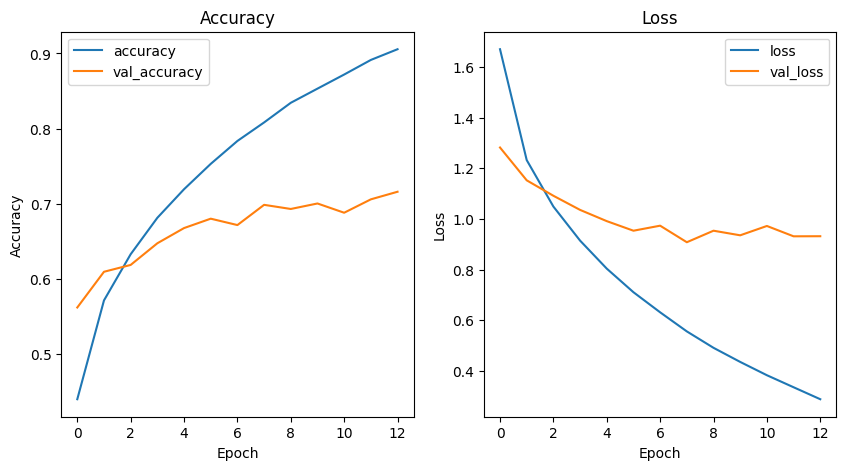

In [25]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121)
ax1.plot(history.history["accuracy"], label="accuracy")
ax1.plot(history.history["val_accuracy"], label="val_accuracy")
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(history.history["loss"], label="loss")
ax2.plot(history.history["val_loss"], label="val_loss")
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

# 모델 배포
## tf_serving을 위한 모델 저장

In [26]:
save_path = os.getenv('HOME') + '/keras/exp_7/mlops/hypermodel/'
fname = os.path.join(save_path, '1')
best_model.export(fname)

INFO:tensorflow:Assets written to: /home/technocracy90/keras/exp_7/mlops/hypermodel/1/assets


INFO:tensorflow:Assets written to: /home/technocracy90/keras/exp_7/mlops/hypermodel/1/assets


Saved artifact at '/home/technocracy90/keras/exp_7/mlops/hypermodel/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_112')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140251641685264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677410512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677410896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677412240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677413392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677411664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677412624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677411472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251676760528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251676760144: TensorSpec(shape=(), dtype=tf.

## 도커를 활용한 모델 배포
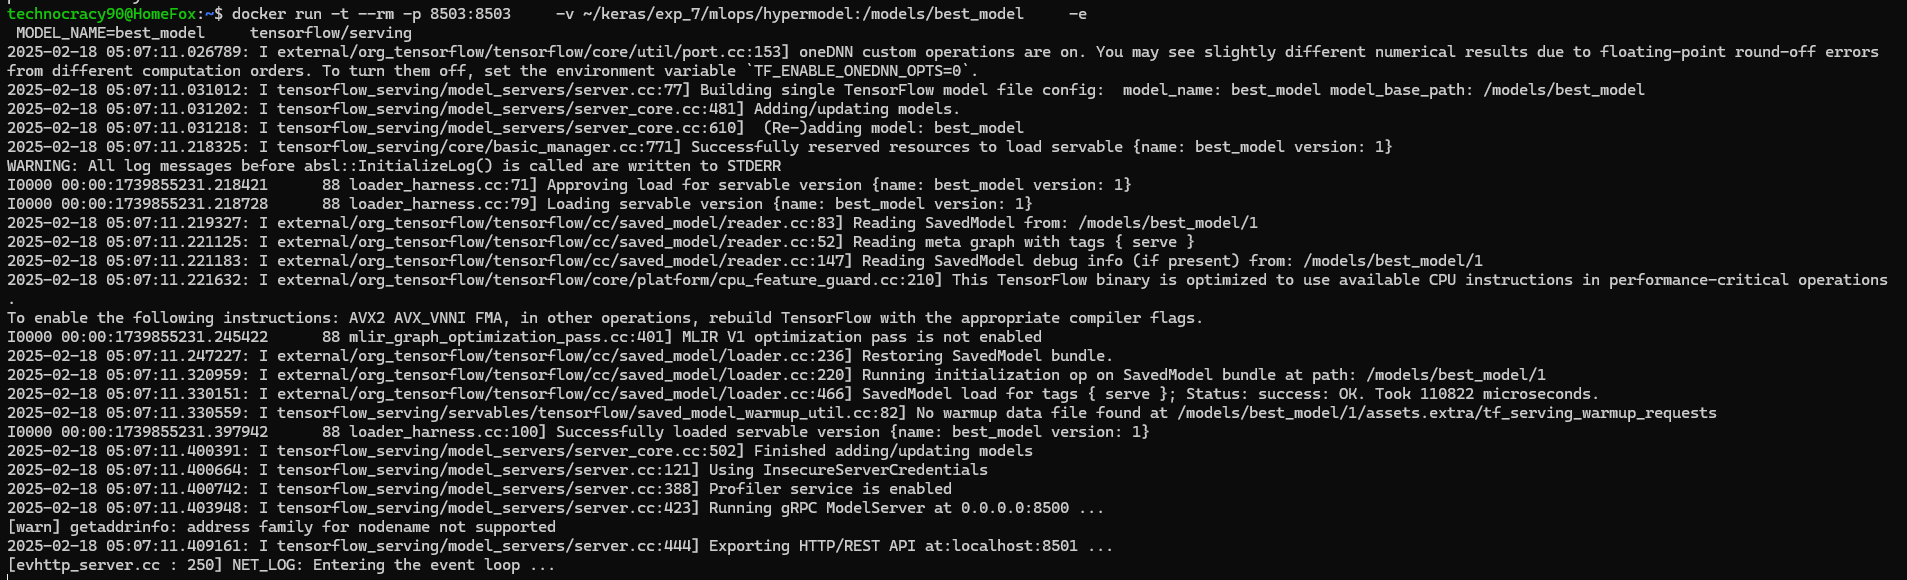

## tf_lite 변환

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_hypermodel = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_hypermodel)
  
interpreter = tf.lite.Interpreter(model_content=tflite_hypermodel)

INFO:tensorflow:Assets written to: /tmp/tmpsm83cvs5/assets


INFO:tensorflow:Assets written to: /tmp/tmpsm83cvs5/assets


Saved artifact at '/tmp/tmpsm83cvs5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor_112')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140251641685264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677410512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677410896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677412240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677413392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677411664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677412624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251677411472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251676760528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140251676760144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14025167741

W0000 00:00:1739855441.220997   64696 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739855441.221034   64696 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-18 14:10:41.221437: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsm83cvs5
2025-02-18 14:10:41.221889: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-18 14:10:41.221896: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpsm83cvs5
I0000 00:00:1739855441.227549   64696 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-02-18 14:10:41.228488: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-18 14:10:41.269851: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpsm83cvs5
2025-02-18 14:10:41.278714: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

In [28]:
signatures = interpreter.get_signature_list()
print(signatures)

{'serving_default': {'inputs': ['keras_tensor_112'], 'outputs': ['output_0']}}
